# Semantic Graph Visualizer

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
from itertools import groupby
import random
from graph_processor import MapProcessor
from load_sequences import SequenceLoader

In [2]:
BASE_DIR = '/home/paok/Documents/test_maps/'
AIRPORT  = 'ksea'
OUT_DIR = f"./out/graph_visualization/{AIRPORT}/semantic_graph/"
processor = MapProcessor(BASE_DIR, OUT_DIR, AIRPORT, load_simplified= True)

In [3]:
processor.graph._node.keys()

dict_keys([-25379, -25455, -25466, -25495, -25510, -25571, -25572, -25573, -25659, -25666, -25712, -25727, -25758, -25801, -25869, -25870, -25871, -25940, -25941, -25942, -25980, 305, 312, 386, 444, 446, 462, 491, 652, 901, 1049, 1187, 1189, 1223, 1264, 1321, 1326, 1328, 1330, 1336, 1359, 1502, 1538, 1604, 1633, 1717, 1718, 1719, 1721, 1799, 1838, 1864, 1983, 2043, 2046, 2055, 2065, 2066, 2067, 2070, 2077, 2083, 2085, 2086, 2089, 2092, 2093, 2095, 2099, 2100, 2106, 2194, 2333, 2428, 2507, 2508, 2519, 2594, 2607, 2617, 2624, 2630, 2814, 2827, 2828, 2870, 2888, 2889, 2898, 2911, 2916, 2925, 3006, 3063, 3126, 3127, 3165, 3202, 3215, 3216, 3264, 3293, 3381, 3383, 3384, 3385, 3386, 3388, 3391, 3446, 3495, 3521, 3647, 3690, 3695, 3791, 3794, 3811, 3859, 3987, 4090, 4147, 4150, 4350, 4358, 4410, 4448, 4496, 4586, 4624, 4641, 4662, 4743, 4763, 4848, 4900, 4925, 4964, 5107, 5183, 5184, 5186, 5188, 5191, 5195, 5268, 5362, 5376, 5474, 5477, 5578, 5634, 5674, 5709, 5728, 5779, 5794, 5917, 5951, 60

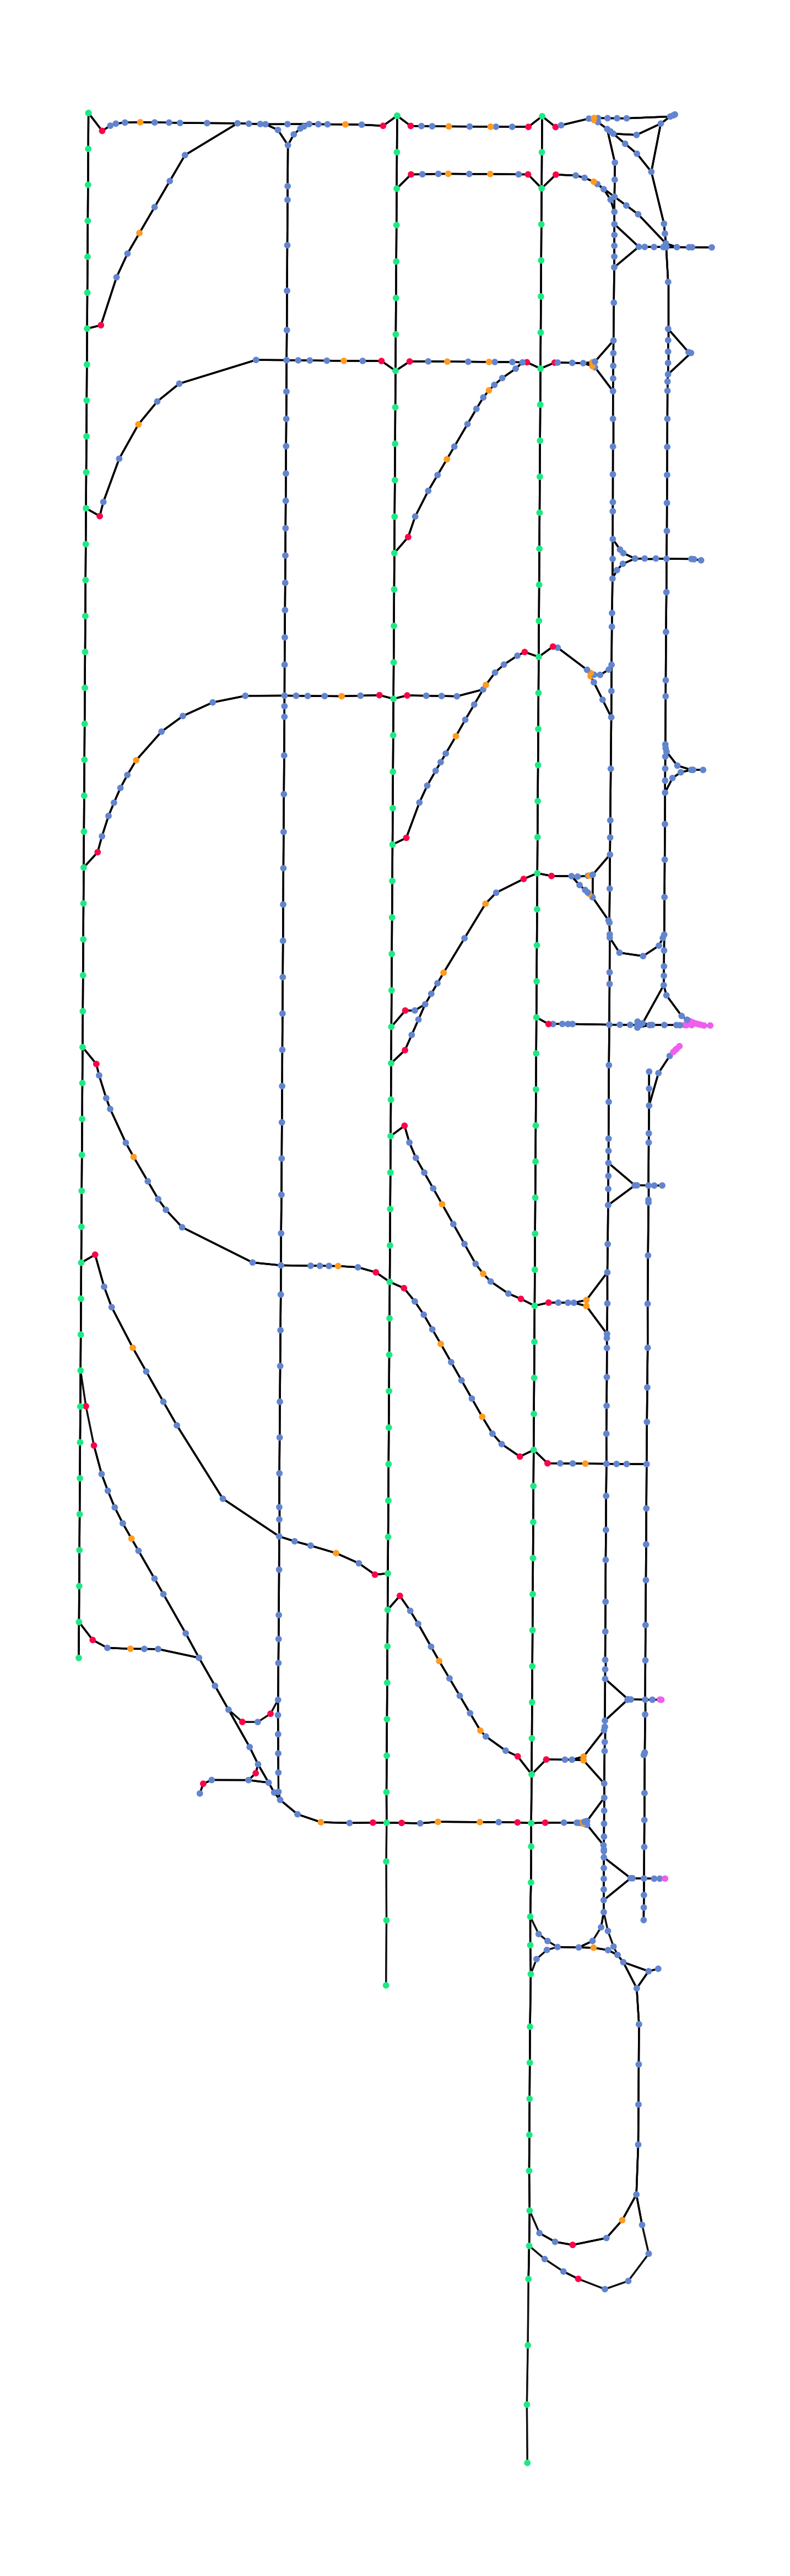

In [4]:

processor.display_and_save(False)

In [ ]:
processor.get_routing_graph()
processor.display_and_save(False)

In [ ]:
processor.pad_centerline(node_separation = 60)
processor.display_and_save(False)

In [ ]:
processor.connect_to_runway()
processor.display_and_save(False)

In [ ]:
processor.sanitize()
processor.display_and_save(True)

In [ ]:
print(f'Orginal graph size: {len(processor.graph)}')

In [ ]:
edges_gdf = ox.graph_to_gdfs(processor.graph, nodes=False, edges=True)
edges_gdf.describe()

In [ ]:
processor.subsample_roadgraph(zone='taxiway',path_depth=4)
processor.display_and_save(False)

In [ ]:
print(f'Subsampled graph size: {len(processor.graph)}')

In [ ]:
edges_gdf = ox.graph_to_gdfs(processor.graph, nodes=False, edges=True)
edges_gdf.describe()

In [ ]:
airport_graph = processor.graph
airport_graph.number_of_edges()

# Projecting path

In [ ]:
TRAJECTORIES_DIR = os.path.join(BASE_DIR, 'raw_trajectories', AIRPORT)
MAP_DIR = os.path.join(BASE_DIR, 'maps', AIRPORT)
LIMITS_FILE = os.path.join(MAP_DIR, 'limits.json')
with open(LIMITS_FILE, 'r') as f:
    ref_data = json.load(f)
TRAJECTORY_FILES = [os.path.join(TRAJECTORIES_DIR, f) for f in os.listdir(TRAJECTORIES_DIR)]
AIRPORT_NAME = ref_data['airport_name']
CRS = ref_data['crs']
ESPG = int(CRS.split(':')[-1])
LAT_MIN, LAT_MAX = ref_data['limits']['lat']
LON_MIN, LON_MAX = ref_data['limits']['lon']
MAP_FILE = os.path.join(MAP_DIR, ref_data['map_shapefile'])
LIMITS_BBOX = (LAT_MIN, LAT_MAX, LON_MIN, LON_MAX)

In [ ]:
def compute_route(G, Lon, Lat):
    nearest_nodes, distance = ox.distance.nearest_nodes(G, Lon, Lat, return_dist=True)
    distance = np.asarray(distance)
    nearest_nodes = [n[0] for n in groupby(nearest_nodes)]
    
    if len(nearest_nodes) <= 1:
        return []
    
    origen = nearest_nodes[:-1]
    destination = nearest_nodes[1:]
    route = []
    path = None
    for o, d in zip(origen, destination):
        # Pairwise starts and ends
        path = ox.distance.shortest_path(G, o, d)
        if not path is None:
            route += path[:-1]
        else:
            print('No possible route for',o,d)
    if not path is None:
        route += [path[-1]]
    else:
        print('Not posible to create path')
        return route
    return route

In [ ]:
seq_loader = SequenceLoader()
traj_file = random.choice(TRAJECTORY_FILES)
sequences = seq_loader.process_file(traj_file)
idx = seq_loader.idxs
test_sequence = random.choice(sequences)
num_agents, _, _ = test_sequence.shape            
ego_id = random.randint(a=0, b=num_agents-1)
ego_sequence = test_sequence[ego_id]

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (20, 45))
offset = 0.0008

Lon, Lat = ego_sequence[:,seq_loader.idxs['Lon']], ego_sequence[:,seq_loader.idxs['Lat']]
lon_min, lon_max = min(Lon) - offset, max(Lon) + offset
lat_min, lat_max = min(Lat) - offset, max(Lat) + offset

bbox = (lat_min, lat_max, lon_min, lon_max)
ax[0].set_xlim(xmin=lon_min, xmax=lon_max)
ax[0].set_ylim(ymin=lat_min, ymax=lat_max)
ax[1].set_xlim(xmin=lon_min, xmax=lon_max)
ax[1].set_ylim(ymin=lat_min, ymax=lat_max)
nc = processor.get_node_colors()
routes = compute_route(airport_graph, Lon, Lat)
ox.plot_graph(airport_graph, ax=ax[0], bgcolor="white", edge_color='black', edge_linewidth=3, node_size=15, node_color=nc, bbox=bbox, show=False)
ox.plot_graph(airport_graph, ax=ax[1], bgcolor="white", edge_color='black', edge_linewidth=3, node_size=15, node_color=nc, bbox=bbox, show=False)
ax[0].scatter(Lon, Lat, color='r', marker = '.', s=300 )
if(routes!= None and len(routes)>=1): ox.plot_graph_route(airport_graph, routes, route_linewidth = 8, orig_dest_size=250, bgcolor="white", edge_color='black', edge_linewidth=2, node_size=100, node_color='blue', route_color='r', bbox=bbox, show=True, ax=ax[1])

# Projecting path to graph using calculated node_lon, node_lat

In [ ]:
TRAJECTORIES_DIR = os.path.join(BASE_DIR, 'raw_trajectories_snap', AIRPORT)
TRAJECTORY_FILES = [os.path.join(TRAJECTORIES_DIR, f) for f in os.listdir(TRAJECTORIES_DIR)]
test_traj = random.choice(TRAJECTORY_FILES)
data = pd.read_csv(test_traj)
data.head()

In [ ]:
unique_IDs = data.ID.unique()
num_trajs = 100
fig, ax = plt.subplots(figsize = (20, 45))
ox.plot_graph(airport_graph, ax=ax, bgcolor="white", edge_color='black', edge_linewidth=3, node_size=15, node_color=nc,show=False)
for n, ID in enumerate(unique_IDs):
    if n > num_trajs:
        break
    traj = data[:][data.ID == ID]    
    lon, lat = traj.Lon, traj.Lat
    ax.scatter(lon, lat, color='r', marker = '.', s=300 )

In [ ]:
unique_IDs = data.ID.unique()
num_trajs = 100
fig, ax = plt.subplots(figsize = (20, 45))
ox.plot_graph(airport_graph, ax=ax, bgcolor="white", edge_color='black', edge_linewidth=3, node_size=15, node_color=nc,show=False)
for n, ID in enumerate(unique_IDs):
    if n > num_trajs:
        break
    traj = data[:][data.ID == ID]    
    lon, lat = traj.node_lon, traj.node_lat
    ax.scatter(lon, lat, color='r', marker = '.', s=300 )